In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
import forestplot as fp

In [2]:
df0 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst0.csv.gz")
df1 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst2.csv.gz")
df2 = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/proteomics/data/npx_inst3.csv.gz")

combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"

In [3]:
def prepare_npx_data(df0, df1, df2):
    df = df0.merge(df1, on="sample_names", how="outer", suffixes=("|0", "|1"))
    df2.columns = [f"{c}|2" if c!="sample_names" else "sample_names" for c in df2.columns]
    df = df.merge(df2, on="sample_names", how="outer")
    df = df.set_index("sample_names")
    df.index = df.index.astype(str)
    prefixes = [c+"|" for c in df0.columns if c!="sample_names"]
    grouper = [next(p for p in prefixes if c.startswith(p)) for c in df.columns]
    df_mean = df.groupby(grouper, axis=1).mean()
    df_mean.columns = [c.strip("|") for c in df_mean.columns]
    return df_mean

def prepare_combo_proteomics_data(protein_df, combo_files):
    protein_set = set(protein_df.columns)
    combo_df = pd.concat([pd.read_csv(cf) for cf in combo_files])
    combo_df["genes"] = combo_df.uniq_items.str.replace("Input_", "").str.split("|")
    combo_df["proteomics_data"] = combo_df.genes.apply(lambda g: len(g) == len(set(g).intersection(protein_set)))
    combo_w_proteomics = combo_df.loc[combo_df.proteomics_data==True]
    return combo_w_proteomics

In [4]:
protein_df = prepare_npx_data(df0, df1, df2)
phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs", "bmi_residuals"], dtype={"sample_names": str, "bmi": float, "bmi_prs": float, "bmi_residuals":float})
combo_w_proteomics = prepare_combo_proteomics_data(protein_df, combo_files)

In [5]:
protein_pheno_df = protein_df.merge(phenotype_df, left_index=True, right_on="sample_names")

In [6]:
def prepare_polynomial_features(protein_df, genes, y_var, include_bias):
    protein_gene_df = protein_df.loc[:, genes].dropna()
    X = protein_gene_df.values
    poly = PolynomialFeatures(len(genes), interaction_only=True, include_bias=include_bias)
    X_poly = poly.fit_transform(X)
    y = protein_df.loc[protein_df.index.isin(protein_gene_df.index), y_var].values.reshape(-1,1)
    return X_poly,y

def train_model_sk(X, y):
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    coefs = reg.coef_[0]
    int_conf = (np.nan, np.nan)
    int_p_val = np.nan
    return r2, coefs, int_conf, int_p_val

def train_model_sm(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    r2 = results.rsquared
    coefs = results.params[1:]
    int_conf = results.conf_int()[-1]
    int_p_val = results.pvalues[-1]
    return r2, coefs, int_conf, int_p_val

def train_protein_model(genes, protein_df, y_var, include_bias, model_type):
    model_type_dict = {"sk": train_model_sk, "sm": train_model_sm}
    X_poly, y = prepare_polynomial_features(protein_df, genes, y_var, include_bias)
    r2, coefs, int_conf, int_p_val = model_type_dict[model_type](X_poly, y)
    return r2, coefs, int_conf, int_p_val

def get_protein_coeffs(genes, protein_df, model_type, y_var="bmi_residuals", include_bias=False):
    r2, coefs, int_conf, int_p_val = train_protein_model(genes, protein_df, y_var, include_bias, model_type)
    coefs = dict(zip([f"gene{i}" for i in range(1, len(genes)+1)] + ["interaction"], coefs))
    ser = pd.Series(coefs)
    ser["r2"] = r2
    ser["ci_low"] = int_conf[0]
    ser["ci_high"] = int_conf[1]
    ser["p_val"] = int_p_val
    return ser

def create_coefs_plot(df, figsize=(6,3)):
    fig = fp.forestplot(
        df,  # the dataframe with results data
        estimate="interaction",  # col containing estimated effect size 
        ll="ci_low", hl="ci_high",
        pval="p_val",
        decimal_precision=3,
        varlabel="uniq_items",  # column containing variable label
        color_alt_rows=True,
        table=True,
        annote=["est_ci"],
        annoteheaders=["Est. (95% Conf. Int.)"],
        # group ordering
        sort=True,
        ylabel="Est. (95% Conf. Int.)",  # y-label title
        xlabel="Interaction coefficients",  # x-label title
        xticks=[-0.2, 0, 0.2, 0.4, 0.6],
        figsize=figsize,
        **{"marker": "D",  # set maker symbol as diamond
            "markersize": 75,  # adjust marker size
            "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
            "xlinecolor": "k",  # gray color for x-reference line
            "xline": 0,
            "xlinewidth": 1,
            "xtick_size": 12,  # adjust x-ticker fontsize
            "lw": 3,
            }       
        )
    return fig

In [7]:
combo_w_proteomics_info = combo_w_proteomics.merge(combo_w_proteomics.genes.apply(get_protein_coeffs, args=(protein_pheno_df, "sm", "bmi_residuals", True)), left_index=True, right_index=True)

In [8]:
combo_w_proteomics_info

,uniq_items,combo_samples,genes,proteomics_data,gene1,gene2,interaction,r2,ci_low,ci_high,p_val
63,Input_ARHGEF12|Input_DARS1,1570890|3157380|3626488|3651797|4925717,"[ARHGEF12, DARS1]",True,0.099197,-0.086635,-0.007901,0.006222,-0.015682,-0.000120,4.658144e-02
288,Input_ASGR1|Input_MASP1,2075291|2986366|3785151|4052490|4932327|593068...,"[ASGR1, MASP1]",True,0.939098,0.180001,0.472744,0.143283,0.391876,0.553612,2.366766e-30
331,Input_MMP3|Input_NOS1,1302678|1498485|1545093|1894831|2725201|333276...,"[MMP3, NOS1]",True,-0.111599,0.210744,-0.037035,0.018477,-0.055654,-0.018416,9.688474e-05
360,Input_IL18RAP|Input_SULT1A1,1925222|3960320|4162091|4375936|4741462,"[IL18RAP, SULT1A1]",True,-0.009537,-0.004466,0.000396,0.000421,-0.002803,0.003596,8.080784e-01
462,Input_AZU1|Input_FUT8,2373201|3521462|4071650|4878576|4914967|581568...,"[AZU1, FUT8]",True,0.121190,0.044450,0.006555,0.012713,-0.009482,0.022591,4.230834e-01
496,Input_HMOX2|Input_TGFBR2,1060060|1181443|1337069|1839502|3843163|389913...,"[HMOX2, TGFBR2]",True,0.105827,0.721290,-0.096145,0.091302,-0.136025,-0.056264,2.305442e-06
500,Input_CDHR5|Input_LGALS3,1067405|1147403|2063573|3573636|3814661,"[CDHR5, LGALS3]",True,0.565030,0.281968,0.109766,0.086665,0.056830,0.162703,4.827875e-05
530,Input_GDF15|Input_TGFBI,1374999|1712220|1745065|2082848|2188215|224130...,"[GDF15, TGFBI]",True,0.264157,0.209568,0.114545,0.037083,0.072360,0.156729,1.030862e-07
586,Input_KRT19|Input_TSPAN1,2111154|4085405|4631997|5093339|5289590,"[KRT19, TSPAN1]",True,0.009228,0.023383,0.037755,0.001160,0.020973,0.054538,1.038895e-05


In [9]:
combo_df = pd.concat([pd.read_csv(cf, usecols=["uniq_items", "combo_samples"]) for cf in combo_files], axis=0)

In [10]:
lf = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/lifestyle_factors/data/lifestyle_processed/filtered_lifestyle_binarized.csv.gz")


In [11]:
lf_info = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/lifestyle_factors/data/lifestyle_processed/filtered_lifestyle_info.csv.gz")

In [12]:
lf_info.loc[lf_info.sample_names==3332768]

,sample_names,alcohol,smokecurr,smokepast,met,sleep,tv,computer,cookedvegetable,salad,...,procmeat,poultry,beef,mutton,pork,bread,cereal,tea,coffee,water
190273,3332768,One to three times a month,No,I have never smoked,No,7,2,1,5,0,...,Less than once a week,Once a week,Once a week,Less than once a week,Never,4,2,0,8,1


In [13]:
lf

,Sample_Name,alcohol,met,sleep,cookedvegetable,salad,freshfruit,driedfruit,poultry,bread,cereal,tea,coffee,water,smoke,fish,meat,sedentary
0,1270557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4366755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5448800,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,3351884,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2896181,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502363,4729190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502364,1443003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502365,2614361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502366,1927454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
lf.loc[lf.Sample_Name==3332768]

,Sample_Name,alcohol,met,sleep,cookedvegetable,salad,freshfruit,driedfruit,poultry,bread,cereal,tea,coffee,water,smoke,fish,meat,sedentary
190273,3332768,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [15]:
combo_df.loc[combo_df.combo_samples.str.contains("3332768")]

,uniq_items,combo_samples
331,Input_MMP3|Input_NOS1,1302678|1498485|1545093|1894831|2725201|333276...


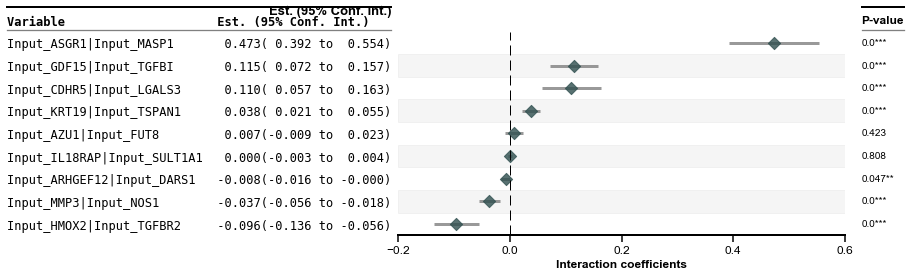

In [16]:
fig = create_coefs_plot(combo_w_proteomics_info, figsize=(8, 4))

In [17]:
protein_pheno_df.loc[protein_pheno_df.sample_names=="3332768", ["MMP3", "NOS1"]]

,MMP3,NOS1
381871,-0.8796,-0.7155


In [9]:
gene1 = "CDHR5"
gene2 = "LGALS3"
protein_gene_pheno_df = protein_pheno_df.loc[:, [gene1, gene2, "bmi_residuals"]].dropna()
protein_gene_pheno_df[f"level_{gene1}"] = pd.qcut(protein_gene_pheno_df[gene1], [0, .25, .5, .75, 1.], ["below", "median1", "median2", "above"])
protein_gene_pheno_df[f"level_{gene1}"] = protein_gene_pheno_df[f"level_{gene1}"].map({"median1": "median", "median2": "median", "above": "above", "below": "below"})
protein_gene_pheno_df[f"level_{gene2}"] = pd.qcut(protein_gene_pheno_df[gene2], [0, .25, .5, .75, 1.], ["below", "median1", "median2", "above"])
protein_gene_pheno_df[f"level_{gene2}"] = protein_gene_pheno_df[f"level_{gene2}"].map({"median1": "median", "median2": "median", "above": "above", "below": "below"})
protein_gene_pheno_df["bmi_res_bins"] = pd.qcut(protein_gene_pheno_df.bmi_residuals, 10, labels=False)

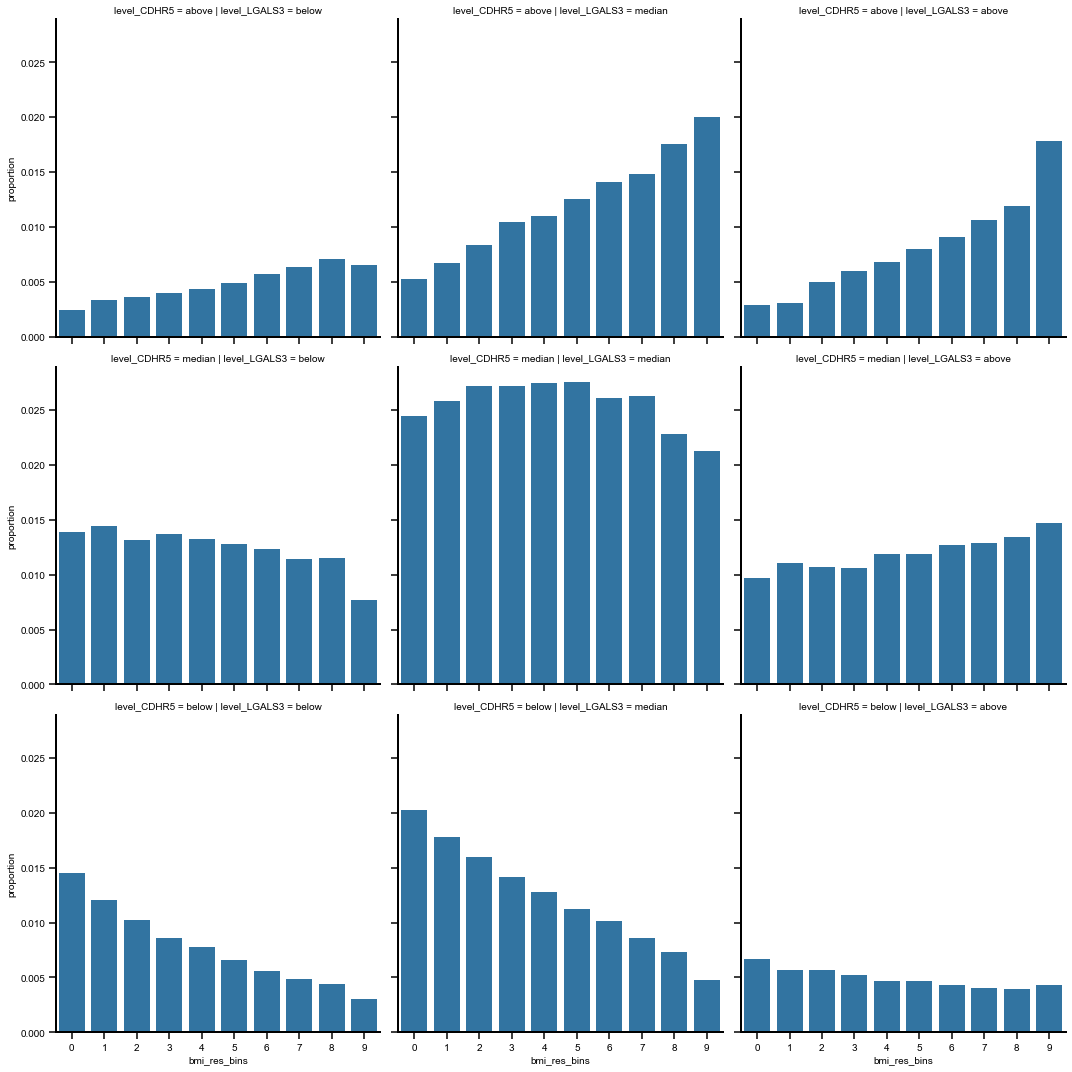

In [10]:
g = sns.catplot(
    data=protein_gene_pheno_df,
    x="bmi_res_bins",
    row=f"level_{gene1}",
    col=f"level_{gene2}",
    row_order=["above", "median", "below"],
    col_order=["below", "median", "above"],
    kind="count",
    stat="proportion",
    sharex=True,
    sharey=True,
    )

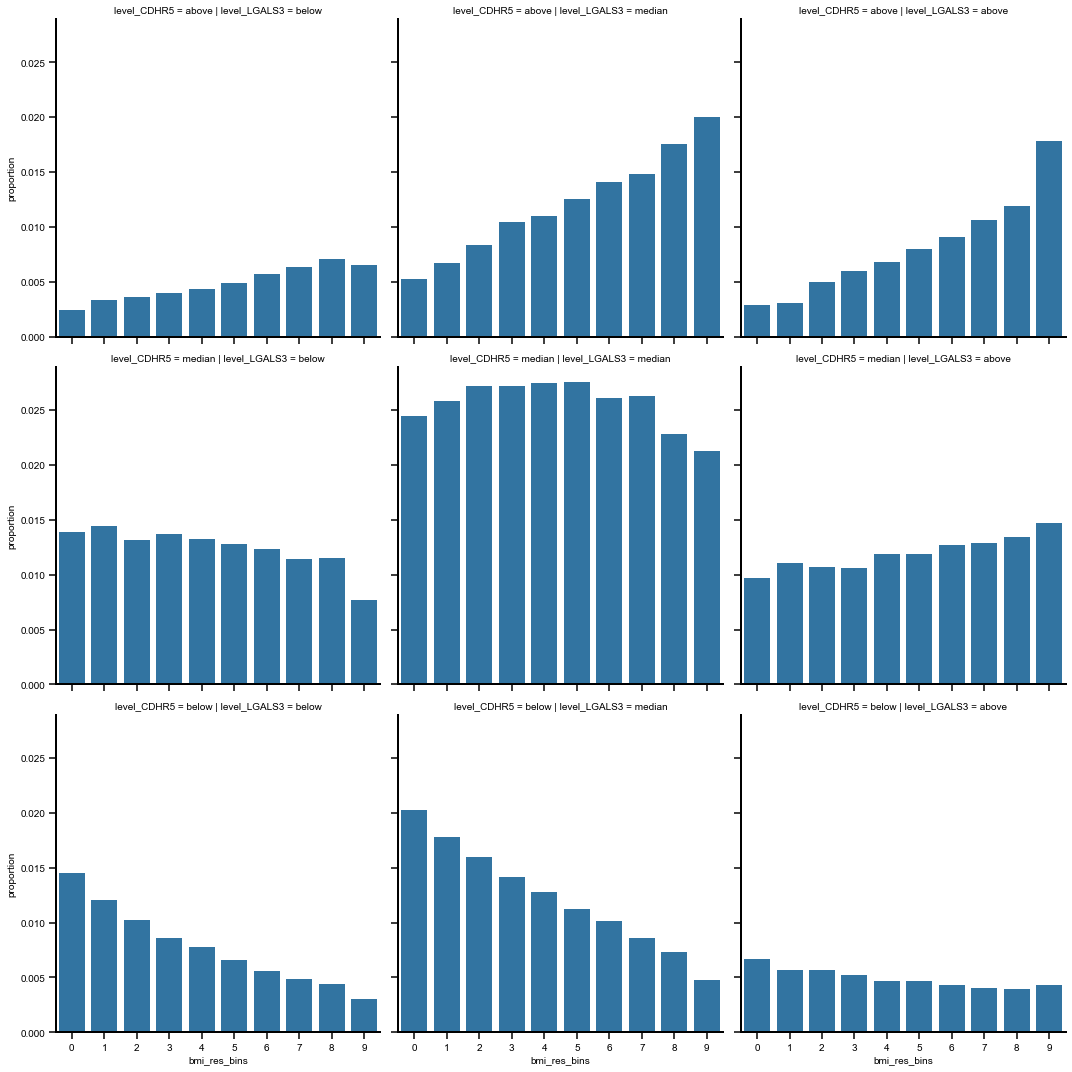

In [11]:
g.figure

In [12]:
ml = [1, 2]

In [13]:
a,b = ml

In [14]:
a

1

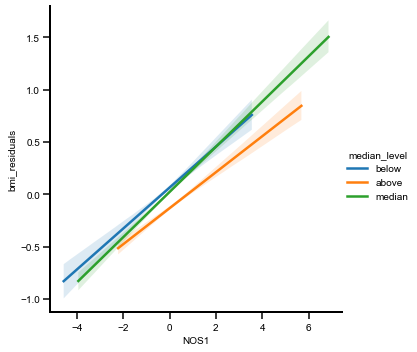

In [75]:
sns.lmplot(data=protein_gene_pheno_df, x="NOS1", y="bmi_residuals", hue="median_level", scatter=False, line_kws={"lw": 2.5})

In [32]:
protein_gene_pheno_df

,MMP3,NOS1,bmi_residuals,median_level
4,-0.4809,-0.32890,0.292562,below
10,-0.7367,0.54235,1.885471,above
17,-0.4724,1.98740,-0.060428,above
25,0.5179,-0.03620,0.043617,median
52,0.3838,0.58630,0.948840,above
...,...,...,...,...
375395,0.1981,0.20670,-0.383538,median
175909,0.6942,0.73640,0.300466,above
155428,-0.5719,-0.76800,0.463671,below
364666,-0.3854,-0.14110,-0.160120,median


<AxesSubplot: xlabel='NOS1', ylabel='bmi_residuals'>

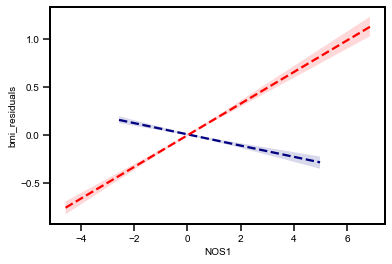

In [9]:
gene1, gene2 = ["MMP3", "NOS1"]	
protein_gene_df = protein_df.loc[:, [gene1, gene2]]
protein_gene_plot_df = phenotype_df.merge(protein_gene_df, left_on="sample_names", right_index=True)

fig, axes = plt.subplots(figsize=(6,4))
sns.regplot(protein_gene_plot_df, x=gene1, y="bmi_residuals", scatter=False, line_kws={"ls": "--", "color":"navy"}, ax=axes)
sns.regplot(protein_gene_plot_df, x=gene2, y="bmi_residuals", scatter=False, line_kws={"ls": "--", "color":"red"}, ax=axes)

<AxesSubplot: xlabel='TGFBR2', ylabel='bmi_residuals'>

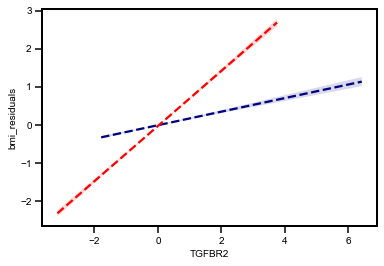

In [10]:
gene1, gene2 = ["HMOX2", "TGFBR2"]
protein_gene_df = protein_df.loc[:, [gene1, gene2]]
protein_gene_plot_df = phenotype_df.merge(protein_gene_df, left_on="sample_names", right_index=True)

fig, axes = plt.subplots(figsize=(6,4))
sns.regplot(protein_gene_plot_df, x=gene1, y="bmi_residuals", scatter=False, line_kws={"ls": "--", "color":"navy"}, ax=axes)
sns.regplot(protein_gene_plot_df, x=gene2, y="bmi_residuals", scatter=False, line_kws={"ls": "--", "color":"red"}, ax=axes)

In [11]:
gene1_q1 = protein_gene_df[gene1].quantile(0.25)
gene2_q1 = protein_gene_df[gene2].quantile(0.75)

In [12]:
lower_protein_gene = protein_gene_df.loc[(protein_gene_df[gene1]<gene1_q1)&(protein_gene_df[gene2]>gene2_q1)]

In [13]:
phenotype_df.merge(lower_protein_gene, left_on="sample_names", right_index=True).bmi_residuals.describe()

count    1924.000000
mean        0.241466
std         1.044177
min        -2.130409
25%        -0.476233
50%         0.061744
75%         0.805065
max         5.393990
Name: bmi_residuals, dtype: float64

In [14]:
phenotype_df.loc[phenotype_df.sample_names.isin(protein_df.index)].bmi_residuals.describe()

count    45646.000000
mean         0.004261
std          0.957826
min         -2.763527
25%         -0.639910
50%         -0.133627
75%          0.488771
max          8.554310
Name: bmi_residuals, dtype: float64

In [15]:
phenotype_df.bmi_residuals.describe()

count    4.276390e+05
mean     4.220332e-18
std      9.565616e-01
min     -3.230953e+00
25%     -6.463729e-01
50%     -1.343953e-01
75%      4.900159e-01
max      9.637921e+00
Name: bmi_residuals, dtype: float64

In [16]:
phenotype_df

,sample_names,bmi_prs,bmi,bmi_residuals
0,1000028,-0.652309,25.50385,-0.408359
1,1000045,-1.084330,23.71090,-0.462484
2,1000171,-0.980411,30.92310,0.985810
3,1000196,0.032952,19.57480,-1.554883
4,1000222,0.092755,30.00600,0.292562
...,...,...,...,...
427634,6024948,0.321514,47.22080,3.942332
427635,6025016,-1.162700,26.56900,-0.024413
427636,6025119,0.968325,30.07590,0.120928
427637,6025181,-0.119517,26.49910,-0.211799


In [17]:
phenotype_df.bmi_residuals.min()

-3.2309529579376783

In [18]:
protein_gene_df.describe()

,HMOX2,TGFBR2
count,50399.000000,51741.000000
mean,0.059035,0.035621
std,0.520230,0.395472
min,-1.974000,-3.168050
25%,-0.253500,-0.217700
50%,-0.003500,0.000000
75%,0.276600,0.245150
max,6.430000,3.847250


In [1]:
import pandas as pd

In [20]:
df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/annot_tables_vep109/chrY/block_0.tsv.gz", sep="\t")

In [21]:
df

,Unnamed: 0,locus,alleles,gene,lof,missense,splice_lof,splice,del_score,samples
0,0,chrY:2787010,G_C,SRY,True,False,False,False,0.0,4526487
1,1,chrY:2787015,G_T,SRY,False,True,False,False,1.0,"2879588,1352246"
2,2,chrY:2787029,G_C,SRY,False,True,False,False,1.0,"2313144,2195223"
3,3,chrY:2787032,G_A,SRY,False,True,False,False,2.0,"2643386,2458240"
4,4,chrY:2787039,C_A,SRY,False,True,False,False,2.0,1569319
...,...,...,...,...,...,...,...,...,...,...
3501,3501,chrY:25043948,G_C,BPY2C,False,True,False,True,0.0,"5909788,3214512,5472002"
3502,3502,chrY:25043967,A_C,BPY2C,False,True,False,False,1.0,1016548
3503,3503,chrY:25043992,C_T,BPY2C,False,True,False,False,1.0,"6022434,3467834,2540956,3472736,5095991,187475..."
3504,3504,chrY:25044001,G_T,BPY2C,False,True,False,False,1.0,"1121878,3463333,3148075,5623149"


In [22]:
df.del_score.value_counts()

del_score
0.0    1381
2.0     956
1.0     864
3.0     205
4.0      56
5.0      24
6.0      13
7.0       7
Name: count, dtype: int64

In [6]:
df.loc[df.missense==True, "del_score"].value_counts()

del_score
0.0    1121
2.0     953
1.0     858
3.0     205
4.0      56
5.0      24
6.0      13
7.0       7
Name: count, dtype: int64

In [7]:
df

,Unnamed: 0,locus,alleles,gene,lof,missense,splice_lof,splice,del_score,samples
0,0,chrY:2787010,G_C,SRY,True,False,False,False,0.0,4526487
1,1,chrY:2787015,G_T,SRY,False,True,False,False,1.0,"2879588,1352246"
2,2,chrY:2787029,G_C,SRY,False,True,False,False,1.0,"2313144,2195223"
3,3,chrY:2787032,G_A,SRY,False,True,False,False,2.0,"2643386,2458240"
4,4,chrY:2787039,C_A,SRY,False,True,False,False,2.0,1569319
...,...,...,...,...,...,...,...,...,...,...
3501,3501,chrY:25043948,G_C,BPY2C,False,True,False,True,0.0,"5909788,3214512,5472002"
3502,3502,chrY:25043967,A_C,BPY2C,False,True,False,False,1.0,1016548
3503,3503,chrY:25043992,C_T,BPY2C,False,True,False,False,1.0,"6022434,3467834,2540956,3472736,5095991,187475..."
3504,3504,chrY:25044001,G_T,BPY2C,False,True,False,False,1.0,"1121878,3463333,3148075,5623149"


In [4]:
df.del_score.value_counts()

del_score
0.0    1381
2.0     956
1.0     864
3.0     205
4.0      56
5.0      24
6.0      13
7.0       7
Name: count, dtype: int64